# Support Vector Machine (a.k.a. Large Margin Classification)

## Table Of Contents

1. Implemented SVM with Gaussian kernel
2. Reallife example
3. Error Analysis

# SVM Implementation with Gaussian Kernel

## Boring stuff ... installing packages, importing things, fixing the world

In [9]:
!pip install plotly

The directory '/root/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/root/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [10]:
# importing required modules
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.ticker as mticker
import scipy.optimize
import sklearn.svm
import sklearn.datasets
import sklearn.model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

# some high DPI settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Goal

1. Create training set generator
2. Define cost function
3. Minimize cost function
4. Profit.

## Training set

Generating a training set from random values of a normal distribution. Let $m$ be the amount of training examples. We simply pick $\frac{m}{2}$ randomly distributed (normal distribution, in this example with $\sigma = 0.5$ and $\mu_x = 1, \mu_y = 0$). Each training example is a vector where its first item $x_0^{(i)} = 1$, $x_1^{(i)}$ is generated by $\mathcal{N}(\sigma, \mu_x)$ and $x_2^{(i)}$ is generated by $\mathcal{N}(\sigma, \mu_y)$. All corresponding training targets are set to $y = 0$. We end up with a matrix (data) and a vector (targets). We repeat this procedure with $\mu_x = -1$ and $y = 1$. Construct the training set:

$$X = \left( \begin{array}{ccc}
x_0^{(1)} & x_1^{(1)} & x_2^{(1)} \\
x_0^{(2)} & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
x_0^{(m/2)} & x_1^{(m/2)} & x_2^{(m/2)} \\
x_0^{(m/2+1)} & x_1^{(m/2+1)} & x_2^{(m/2+1)} \\
\vdots & \vdots & \vdots \\
x_0^{(m)} & x_1^{(m)} & x_2^{(m)} \\
\end{array} \right) = \left( \begin{array}{ccc}
1 & x_1^{(1)} & x_2^{(1)} \\
1 & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
1 & x_1^{(m/2)} & x_2^{(m/2)} \\
1 & x_1^{(m/2+1)} & x_2^{(m/2+1)} \\
\vdots & \vdots & \vdots \\
1 & x_1^{(m)} & x_2^{(m)} \\
\end{array} \right)\qquad y = \left( \begin{array}{c}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(m/2)} \\
y^{(m/2+1)} \\
\vdots \\
y^{(m)} \\
\end{array} \right) = \left( \begin{array}{c}
0 \\
0 \\
\vdots \\
0 \\
1 \\
\vdots \\
1 \\
\end{array} \right)$$

### Shuffling

Because we generate first negative examples ($y = 0$) and then positive examples ($y = 1$) it is generally a good idea to shuffle the rows of the training set (the order of the examples). This is done by

1. Initialize $P = I$ (identity matrix)
2. Shuffle $P$
3. Apply permutation to training set: $X = PX$ and $y = Py$

Why not shuffle $X$ and $y$ directly? Because we must shuffle $X$ and $y$ with the same permutation. Furthermore `numpy` can shuffle a 1d-list but not a 2d-matrix. So we have to do that manually.

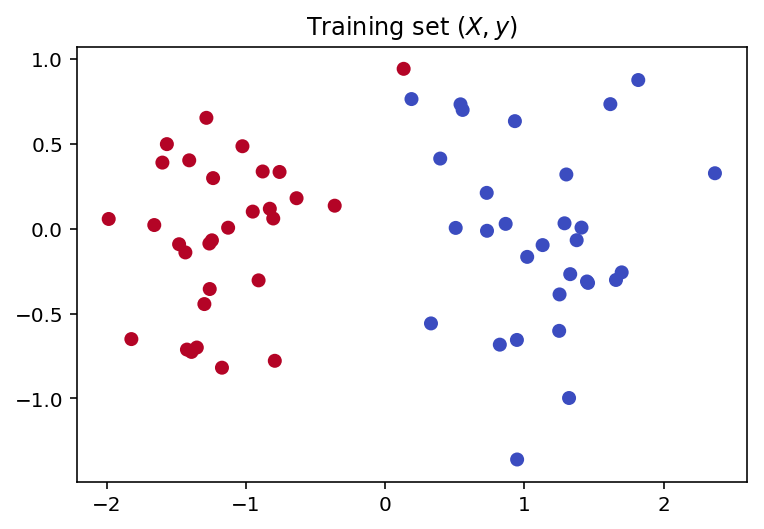

In [11]:
gaussian2d = lambda x, y, sigma, n: (np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))

m = 60
half_m = int(m / 2)
sigma = 0.5

X = np.concatenate((
    np.array(gaussian2d(1, 0, sigma, half_m)).T,   # first half of the training set
    np.array(gaussian2d(-1, 0, sigma, half_m)).T   # second half of the training set
), axis=0)

y = np.concatenate((
    np.repeat(0, half_m), # setting results to 0
    np.repeat(1, half_m)  # setting results to 1
), axis=0)

permutation = np.eye(m)
np.random.shuffle(permutation)

# permutate X and y with P
X = np.matmul(permutation, X)
y = np.matmul(permutation, y)

# add ones for x_0
X = np.c_[ np.ones((m, 1)), X ]

plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.title("Training set $(X, y)$")
plt.show()

In [12]:
pd.DataFrame(data=np.c_[ X[:15], y[:15] ], columns=[ "x0 (offset)", "x1 (x)", "x2 (y)", "y (class)" ])

,x0 (offset),x1 (x),x2 (y),y (class)
0,1.0,0.730933,-0.011997,0.0
1,1.0,1.251816,-0.387256,0.0
2,1.0,0.395068,0.413877,0.0
3,1.0,-1.434445,-0.139550,1.0
4,1.0,1.019463,-0.165850,0.0
5,1.0,0.540818,0.733646,0.0
6,1.0,1.287415,0.032160,0.0
7,1.0,-1.262184,-0.087089,1.0
8,1.0,0.945677,-0.655678,0.0
9,1.0,1.409405,0.006820,0.0


## Cost function *J*

### Linear kernel (no kernel)

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T x^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T x^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

### Gaussian kernel (Radial Basis Function, a.k.a. RBF kernel)

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T f^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T f^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

$$J\big(\theta\big) = C \Big( c_1^T y + c_0^T (1 - y) \Big) + \frac{1}{2} \Vert\theta\Vert^2$$

$C$ is the regularization parameter, $c_1$ and $c_0$ are the vectors of all partial costs, $y$ is the training result vector. We obtain $c_1$ and $c_0$ by computing

$$\Big( \theta^T f^{(1)}, \theta^T f^{(2)}, \dots, \theta^T f^{(m)} \Big) = \theta^T \left( \begin{array}{cccc}
1 & 1 & & 1 \\
\vdots & \vdots & & \vdots \\
f^{(1)} & f^{(2)} & \cdots & f^{(m)} \\
\vdots & \vdots & & \vdots \\
\end{array} \right) = \theta^T F =: z$$

$$c_1 = \text{cost}_1(z) = \Big( \text{cost}_1(\theta^T f^{(1)}), \text{cost}_1(\theta^T f^{(2)}), \dots, \text{cost}_1(\theta^T f^{(m)}) \Big)$$
$$c_0 = \text{cost}_0(z) = \Big( \text{cost}_0(\theta^T f^{(1)}), \text{cost}_0(\theta^T f^{(2)}), \dots, \text{cost}_0(\theta^T f^{(m)}) \Big)$$

In [13]:
def J(theta, F, y, C):
    z = np.dot(theta, F)
    c1 = cost1(z)
    c0 = cost0(z)
    sum1 = np.dot(c1, y)
    sum0 = np.dot(c0, (1 - y))
    return C * (sum1 + sum0) + 0.5 * LA.norm(theta[1:])**2

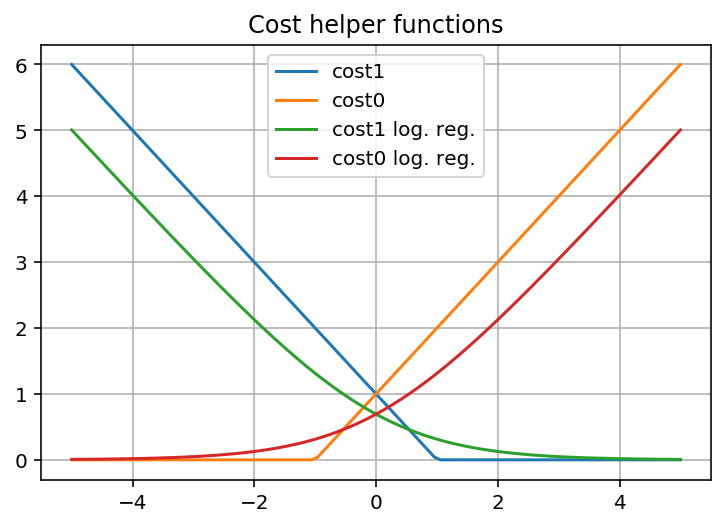

In [14]:
x = np.arange(-5, 5, 0.1)

g = lambda z: 1 / (1 + np.exp(-z))       # sigmoid function g

cost1_log_reg = lambda z: -np.log(g(z))     # cost function for y = 1
cost0_log_reg = lambda z: -np.log(1 - g(z)) # cost function for y = 0

cost1 = lambda z: np.where(z < 1, -z + 1, 0)
cost0 = lambda z: np.where(z > -1, z + 1, 0)

x = np.linspace(-5, 5, 100)
plt.plot(x, cost1(x), label="cost1")
plt.plot(x, cost0(x), label="cost0")
plt.plot(x, cost1_log_reg(x), label="cost1 log. reg.")
plt.plot(x, cost0_log_reg(x), label="cost0 log. reg.")
plt.legend()
plt.title("Cost helper functions")
plt.grid()
plt.show()

## Kernel Function

... computes the similarity between two vectors $x$ and $l$ (given $\sigma$ or $\gamma = \frac{1}{2\sigma^2}$) $$k(x, l) = \exp\Bigg(- \frac{\big\Vert x - l \big\Vert^2}{2\sigma^2}\Bigg) = \exp\Big(- \gamma \Vert x - l \Vert^2\Big)$$

## Feature Matrix

Given a training set $x^{(0)}, x^{(1)}, \dots, x^{(m)} \in \mathbb{R}^{m+1}$, define $l^{(0)} = x^{(0)}, l^{(1)} = x^{(1)}, \dots, l^{(m)} = x^{(m)} \in \mathbb{R}^{m+1}$.

Define the feature matrix $F$ so that $$f_{ij} = k(x^{(j)}, l^{(i)}) = \exp\Big(- \frac{\Vert x^{(j)} - l^{(i)} \Vert^2}{2\sigma^2}\Big)$$

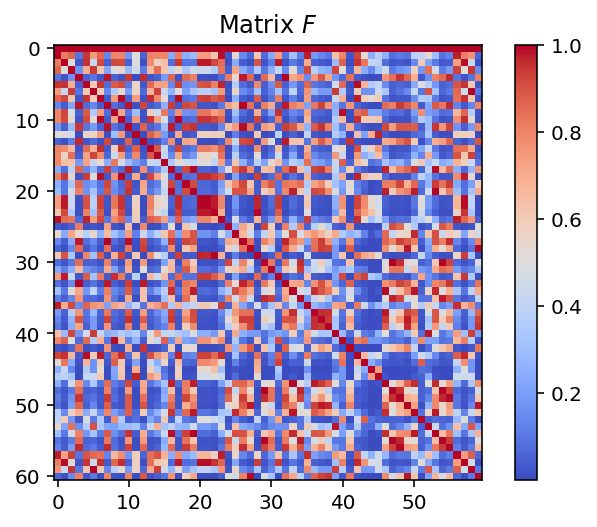

In [15]:
kernel = lambda x, l, sigma: np.exp(- (LA.norm(x - l, ord=2)**2) / (2 * sigma**2))

m = X.shape[0]

vectorized_kernel = np.vectorize(lambda i, j: kernel(X[i], X[j - 1], 1))
F = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m), dtype=int)
F[0, :] = 1

plt.imshow(F, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $F$")
plt.show()

## Finding a minimum

We will get a minimum $\theta$ by minimizing the cost function. This $\theta$ is the normal vector of the decision boundary.

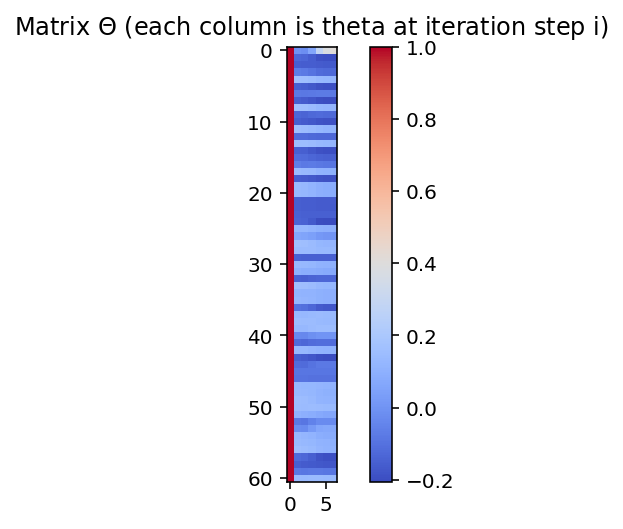

In [16]:
m = X.shape[0]
theta_matrix = np.ones(shape=(m + 1, 1))

def callback(theta):
    global theta_matrix
    theta_matrix = np.c_[ theta_matrix, theta ]

minimum = scipy.optimize.minimize(
    lambda theta: J(np.array(theta), F, y, C=1), x0=(0,)*(m + 1),
    callback=callback
)

theta = minimum.x

plt.imshow(theta_matrix, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $\Theta$ (each column is theta at iteration step i)")
plt.show()

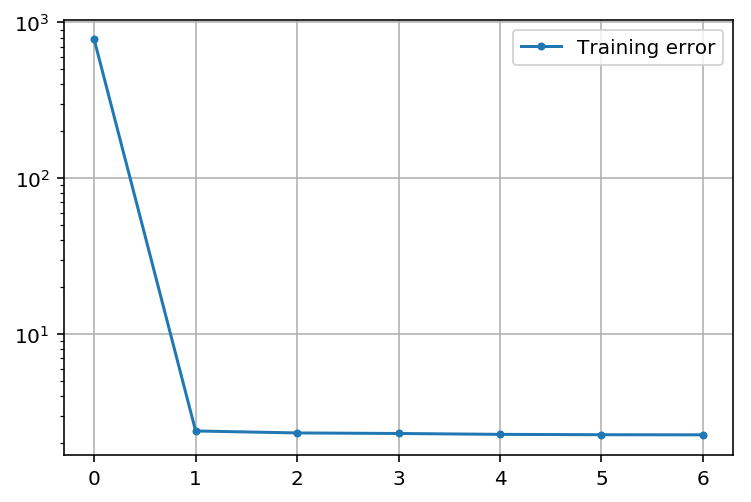

In [17]:
training_error = np.apply_along_axis(lambda theta: J(np.array(theta), F, y, C=1), axis=0, arr=theta_matrix)

plt.semilogy(training_error, label="Training error", marker=".")
plt.legend()
plt.grid()
plt.show()

## Hypothesis

1. Calculate features: $x \rightarrow f$
2. Evaluate:
    * $\theta^T f > 0.5 \Rightarrow$ predict $y = 0$
    * $\theta^T f < 0.5 \Rightarrow$ predict $y = 1$

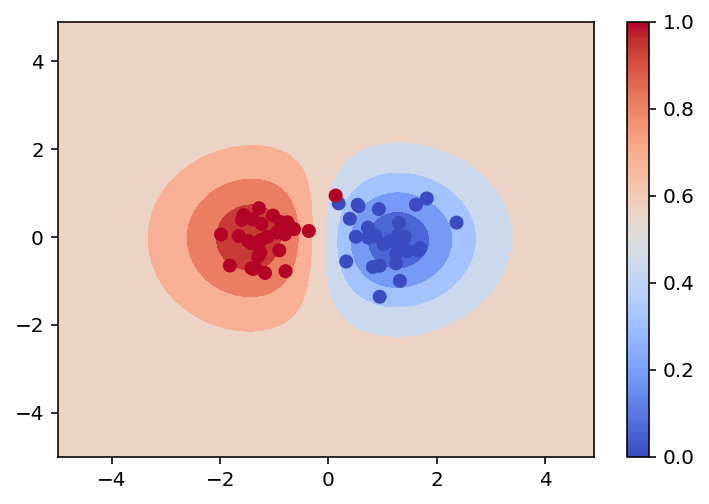

In [18]:
xx, yy = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))

m_mesh = xx.ravel().shape[0]
X_mesh = np.c_[ np.ones((m_mesh, 1)), xx.ravel(), yy.ravel() ]

vectorized_kernel = np.vectorize(lambda i, j: kernel(X_mesh[i], X[j - 1], 1))
F_ = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m_mesh), dtype=int)
F_[0, :] = 1

Z = np.dot(theta, F_)

plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.coolwarm)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

In [19]:
py.iplot([ go.Surface(x=xx, y=yy, z=Z.reshape(xx.shape))])

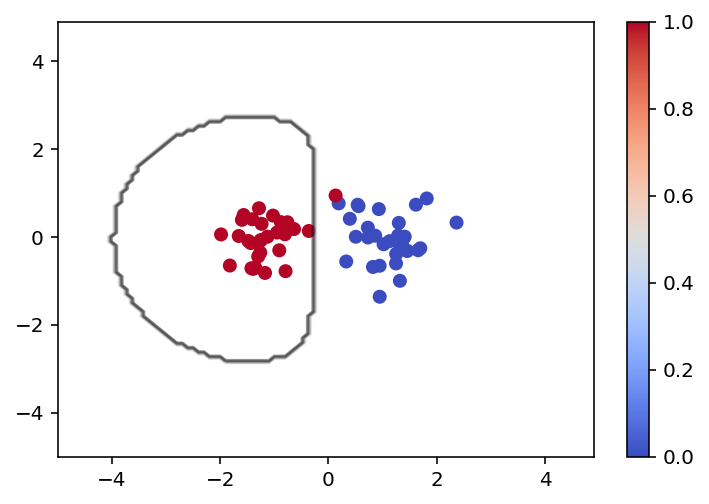

In [20]:
Z_classes = np.vectorize(lambda z: 1 if z > 0.5 else 0)(Z.reshape(xx.shape))

plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.35)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

## Using a library

Performance-tuned implementation of several solving algorithms. Up to 100x faster than the manual implementation above.

### Gaussian kernel

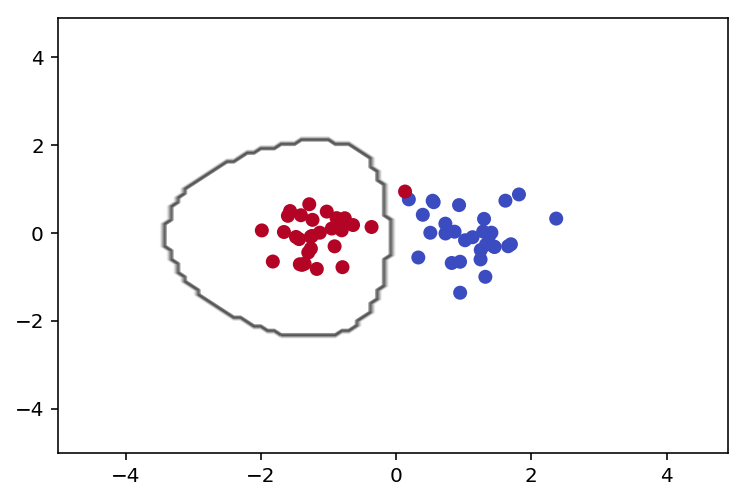

In [21]:
classifier = sklearn.svm.SVC(kernel="rbf", gamma=0.5)
classifier.fit(X, y)

Z_classes = classifier.predict(np.c_[ np.ones((m_mesh, 1)), xx.ravel(), yy.ravel() ])
Z_classes = Z_classes.reshape(xx.shape)

plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.35)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.show()

### Linear kernel

$$J\big(\theta\big) = C \Big( c_1^T y + c_0^T (1 - y) \Big) + \frac{1}{2} \Vert\theta\Vert^2$$

When choosing a high $C$ the optimization algorithm tries to find a small solution $\theta$ to minimize the cost function. A high $C$ makes the solution prone to underfitting (biased solution), whereas a low $C$ allows a larger $\theta$ which means that the solution is more prone to overfitting.

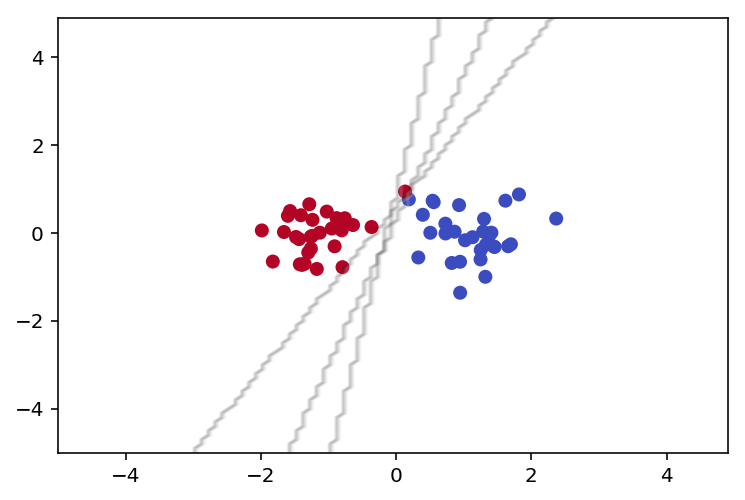

In [22]:
for c in [ 1, 10, 10000 ]:
    classifier = sklearn.svm.SVC(kernel="linear", C=c)
    classifier.fit(X, y)
    
    Z_classes = classifier.predict(np.c_[ np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()])
    Z_classes = Z_classes.reshape(xx.shape)
    plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.1)

plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.show()